# Librerías

# Intento 3: Red neuronal para clasificación de nodos

## Clasificación de nodos - tutorial

In [98]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [99]:
zip_file = keras.utils.get_file(
    fname="cora.tgz",
    origin="https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz",
    extract=True,
)
data_dir = os.path.join(os.path.dirname(zip_file), "cora")

In [100]:
citations = pd.read_csv(
    os.path.join(data_dir, "cora.cites"),
    sep="\t",
    header=None,
    names=["target", "source"],
)
print("Citations shape:", citations.shape)

Citations shape: (5429, 2)


In [101]:
citations.sample(frac=1).head()

,target,source
1625,8874,395075
209,114,91975
1567,8591,709113
2682,29492,29708
1088,5064,1120563


In [102]:
column_names = ["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"]
papers = pd.read_csv(
    os.path.join(data_dir, "cora.content"), sep="\t", header=None, names=column_names,
)
print("Papers shape:", papers.shape)

Papers shape: (2708, 1435)


In [103]:
print(papers.sample(5).T)

             1862        1416                   913                    1608  \
paper_id   107251     1108363                  51052                   7032   
term_0          0           0                      0                      0   
term_1          0           1                      0                      0   
term_2          0           0                      0                      0   
term_3          0           0                      0                      0   
...           ...         ...                    ...                    ...   
term_1429       0           0                      0                      0   
term_1430       0           0                      0                      0   
term_1431       0           0                      0                      0   
term_1432       0           0                      0                      0   
subject    Theory  Case_Based  Probabilistic_Methods  Probabilistic_Methods   

                    2449  
paper_id          263482

In [104]:
print(papers.subject.value_counts())

subject
Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: count, dtype: int64


In [105]:
class_values = sorted(papers["subject"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(papers["paper_id"].unique()))}

papers["paper_id"] = papers["paper_id"].apply(lambda name: paper_idx[name])
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])
papers["subject"] = papers["subject"].apply(lambda value: class_idx[value])

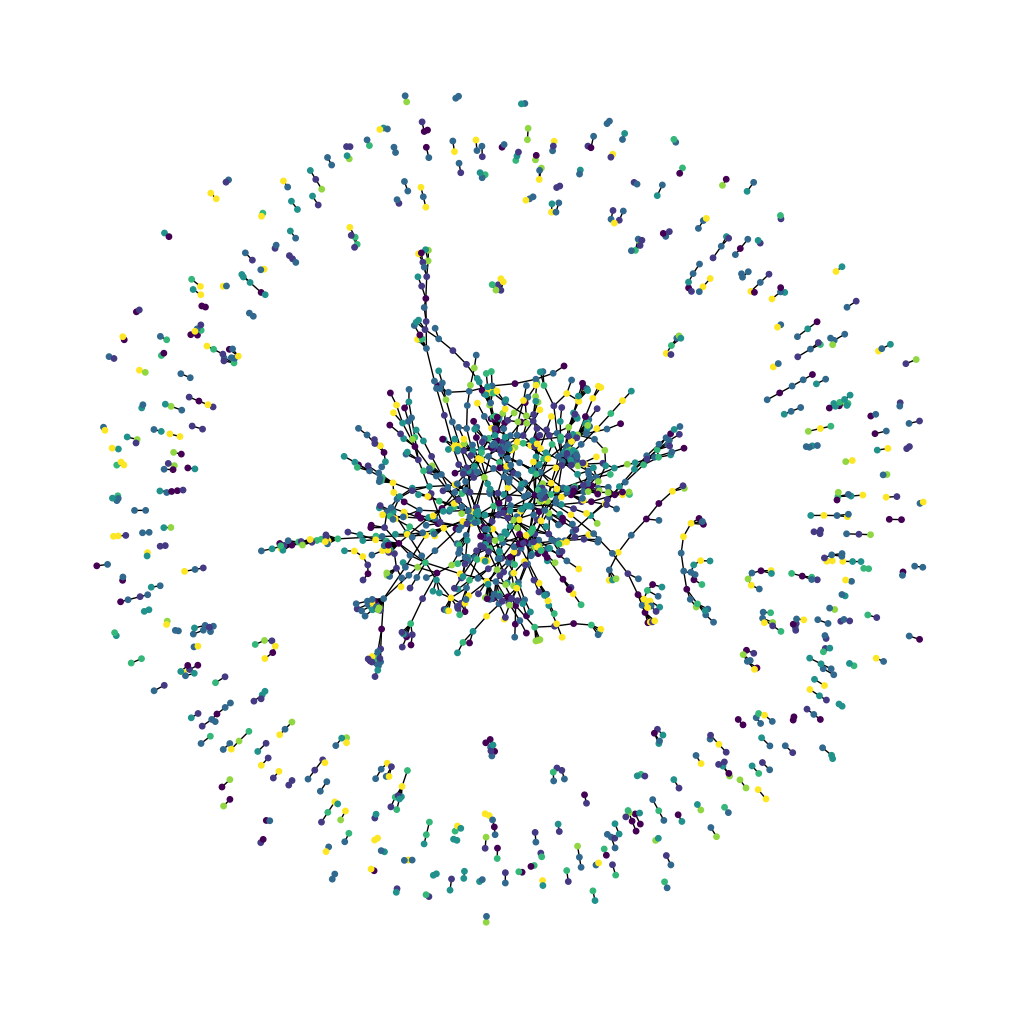

In [106]:
plt.figure(figsize=(10, 10))
colors = papers["subject"].tolist()
cora_graph = nx.from_pandas_edgelist(citations.sample(n=1500))
subjects = list(papers[papers["paper_id"].isin(list(cora_graph.nodes))]["subject"])
nx.draw_spring(cora_graph, node_size=15, node_color=subjects)

In [107]:
train_data, test_data = [], []

for _, group_data in papers.groupby("subject"):
    # Select around 50% of the dataset for training.
    random_selection = np.random.rand(len(group_data.index)) <= 0.5
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (1343, 1435)
Test data shape: (1365, 1435)


In [108]:
hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 30
batch_size = 256

In [109]:
def run_experiment(model, x_train, y_train):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=50, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history

In [110]:
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()

In [111]:
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)

In [112]:
feature_names = list(set(papers.columns) - {"paper_id", "subject"})
num_features = len(feature_names)
num_classes = len(class_idx)

# Create train and test features as a numpy array.
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
# Create train and test targets as a numpy array.
y_train = train_data["subject"]
y_test = test_data["subject"]

In [113]:
def create_baseline_model(hidden_units, num_classes, dropout_rate=0.2):
    inputs = layers.Input(shape=(num_features,), name="input_features")
    x = create_ffn(hidden_units, dropout_rate, name=f"ffn_block1")(inputs)
    for block_idx in range(4):
        # Create an FFN block.
        x1 = create_ffn(hidden_units, dropout_rate, name=f"ffn_block{block_idx + 2}")(x)
        # Add skip connection.
        x = layers.Add(name=f"skip_connection{block_idx + 2}")([x, x1])
    # Compute logits.
    logits = layers.Dense(num_classes, name="logits")(x)
    # Create the model.
    return keras.Model(inputs=inputs, outputs=logits, name="baseline")


baseline_model = create_baseline_model(hidden_units, num_classes, dropout_rate)
baseline_model.summary()

Model: "baseline"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_features (InputLayer  [(None, 1433)]               0         []                            
 )                                                                                                
                                                                                                  
 ffn_block1 (Sequential)     (None, 32)                   52804     ['input_features[0][0]']      
                                                                                                  
 ffn_block2 (Sequential)     (None, 32)                   2368      ['ffn_block1[0][0]']          
                                                                                                  
 skip_connection2 (Add)      (None, 32)                   0         ['ffn_block1[0][0]',   

In [114]:
history = run_experiment(baseline_model, x_train, y_train)

Epoch 1/30
5/5 [==============================] - 2s 50ms/step - loss: 3.4190 - acc: 0.1744 - val_loss: 1.9069 - val_acc: 0.1931
Epoch 2/30
5/5 [==============================] - 0s 9ms/step - loss: 2.6401 - acc: 0.2209 - val_loss: 1.8785 - val_acc: 0.1931
Epoch 3/30
5/5 [==============================] - 0s 9ms/step - loss: 2.3513 - acc: 0.2209 - val_loss: 1.8639 - val_acc: 0.2673
Epoch 4/30
5/5 [==============================] - 0s 10ms/step - loss: 2.1079 - acc: 0.2656 - val_loss: 1.8470 - val_acc: 0.3416
Epoch 5/30
5/5 [==============================] - 0s 9ms/step - loss: 2.0173 - acc: 0.2480 - val_loss: 1.8148 - val_acc: 0.4010
Epoch 6/30
5/5 [==============================] - 0s 8ms/step - loss: 1.8898 - acc: 0.3015 - val_loss: 1.7878 - val_acc: 0.3713
Epoch 7/30
5/5 [==============================] - 0s 8ms/step - loss: 1.8224 - acc: 0.3357 - val_loss: 1.7585 - val_acc: 0.3218
Epoch 8/30
5/5 [==============================] - 0s 10ms/step - loss: 1.7396 - acc: 0.3453 - val_loss

## Clustering con NN

## Prueba con GNNS

In [140]:
import bz2

In [145]:
archivo_bz2 = "karate.graph.bz2"

# Abrir el archivo comprimido y leer su contenido
with bz2.open(archivo_bz2, "rt") as archivo_comprimido:
    contenido = archivo_comprimido.read()

contenido = contenido.split('\n')
#contenido = [c.split() for c in contenido]

In [151]:
G = nx.DiGraph()
i = 0
n = 0
m = 0
fmt = 0
with bz2.open(archivo_bz2, "rt") as f:
    for line in f:
        print(line)
        line = line.strip()
        if len(line) == 0:
            if i > 0:
                i += 1
        elif line[0] != '%':
            values = [int(x) for x in line.split()]
            if i == 0:
                n, m = values[:2]
                if len(values) > 2:
                    fmt = values[2]
                if fmt > 1:
                    print("Error in file: ", name, " unsupported format!")
                    break
                G.add_nodes_from(range(n))
            else:
                if fmt == 0:
                    G.add_edges_from([(i-1, j-1) for j in values])
                elif fmt == 1:
                    G.add_weighted_edges_from([(i-1, j-1, w) for j, w in zip(values[::2], values[1::2])])
            i += 1
    G.name = name[:-10]
    num_selfloops = len(list(nx.selfloop_edges(G)))

34 78 0

2 3 4 5 6 7 8 9 11 12 13 14 18 20 22 32 

1 3 4 8 14 18 20 22 31 

1 2 4 8 9 10 14 28 29 33 

1 2 3 8 13 14 

1 7 11 

1 7 11 17 

1 5 6 17 

1 2 3 4 

1 3 31 33 34 

3 34 

1 5 6 

1 

1 4 

1 2 3 4 34 

33 34 

33 34 

6 7 

1 2 

33 34 

1 2 34 

33 34 

1 2 

33 34 

26 28 30 33 34 

26 28 32 

24 25 32 

30 34 

3 24 25 34 

3 32 34 

24 27 33 34 

2 9 33 34 

1 25 26 29 33 34 

3 9 15 16 19 21 23 24 30 31 32 34 

9 10 14 15 16 19 20 21 23 24 27 28 29 30 31 32 33 



